Bollinger bands

Bollinger band definition from investopedia:
https://www.investopedia.com/terms/b/bollingerbands.asp

$$ BOLU = MA(TP, n) + m * \sigma(TP, n) $$   
$$ BOLU = MA(TP, n) - m * \sigma(TP, n) $$

MA ... Moving Average
TP (typical price) = (High + Low + Close) / 3
n = 
m = 
$\sigma(TP, n)$



In [226]:
#optional installations: 
#!pip install yfinance --upgrade --no-cache-dir
#!pip3 install pandas_datareader


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# ___library_import_statements___
import pandas as pd

# for pandas_datareader, otherwise it might have issues, sometimes there is some version mismatch
pd.core.common.is_list_like = pd.api.types.is_list_like

# make pandas to print dataframes nicely
pd.set_option('expand_frame_repr', False)  

import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time

#newest yahoo API 
import yfinance as yahoo_finance

#optional 
#yahoo_finance.pdr_override()

%matplotlib inline

In [227]:
# ___variables___
#ticker = 'AAPL'
#ticker = 'TSLA'
#ticker = 'GOOGL'
#ticker = 'NFLX'
ticker = 'GOOG'


start_time = datetime.datetime(2017, 1, 1)
#end_time = datetime.datetime(2019, 1, 20)
end_time = datetime.datetime.now().date().isoformat()         # today


In [228]:
# yahoo gives only daily historical data
connected = False
while not connected:
    try:
        ticker_df = web.get_data_yahoo(ticker, start=start_time, end=end_time)
        connected = True
        print('connected to yahoo')
    except Exception as e:
        print("type error: " + str(e))
        time.sleep( 5 )
        pass   

# use numerical integer index instead of date    
#ticker_df = ticker_df.reset_index()
print(ticker_df.head(5))

connected to yahoo
                  High         Low        Open       Close   Volume   Adj Close
Date                                                                           
2017-01-03  789.630005  775.799988  778.809998  786.140015  1657300  786.140015
2017-01-04  791.340027  783.159973  788.359985  786.900024  1073000  786.900024
2017-01-05  794.479980  785.020020  786.080017  794.020020  1335200  794.020020
2017-01-06  807.900024  792.203979  795.260010  806.150024  1640200  806.150024
2017-01-09  809.966003  802.830017  806.400024  806.650024  1274600  806.650024


In [229]:
df = ticker_df

In [230]:
#### RESAMPLING TO WEEKLY TO CLEAN NOISE

agg_dict = {'Open': 'first',
          'High': 'max',
          'Low': 'min',
          'Close': 'last',
          'Adj Close': 'last',
          'Volume': 'mean'}

# resampled dataframe
# 'W' means weekly aggregation
df = df.resample('W').agg(agg_dict)

df = df.reset_index()


In [231]:
def computeRSI (data, time_window):
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=time_window-1 so we get decay alpha=1/time_window
    up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

In [232]:
def bollinger_bands(df, n, m):
    # takes dataframe on input
    # n = smoothing length
    # m = number of standard deviations away from MA
    
    #typical price
    TP = (df['High'] + df['Low'] + df['Close']) / 3
    # but we will use Adj close instead for now, depends
    
    data = TP
    #data = df['Adj Close']
    
    # takes one column from dataframe
    B_MA = pd.Series((data.rolling(n, min_periods=n).mean()), name='B_MA')
    sigma = data.rolling(n, min_periods=n).std() 
    
    BU = pd.Series((B_MA + m * sigma), name='BU')
    BL = pd.Series((B_MA - m * sigma), name='BL')
    
    df = df.join(B_MA)
    df = df.join(BU)
    df = df.join(BL)
    
    return df

In [233]:
df = bollinger_bands(df, 20, 2)

In [234]:
print(df.head())
print(df.tail())

        Date        Open        High         Low       Close   Adj Close   Volume  B_MA  BU  BL
0 2017-01-08  778.809998  807.900024  775.799988  806.150024  806.150024  1426425   NaN NaN NaN
1 2017-01-15  806.400024  811.223999  799.169983  807.880005  807.880005  1193920   NaN NaN NaN
2 2017-01-22  807.080017  809.479980  800.369995  805.020020  805.020020  1311450   NaN NaN NaN
3 2017-01-29  807.250000  841.950012  803.739990  823.309998  823.309998  2174360   NaN NaN NaN
4 2017-02-05  814.659973  815.840027  790.520020  801.489990  801.489990  2086480   NaN NaN NaN
          Date         Open         High          Low        Close    Adj Close   Volume         B_MA           BU           BL
192 2020-09-13  1533.510010  1584.081055  1497.359985  1520.719971  1520.719971  1900325  1468.522884  1641.529733  1295.516036
193 2020-09-20  1539.005005  1564.000000  1437.130005  1459.989990  1459.989990  1864620  1477.661552  1632.490130  1322.832974
194 2020-09-27  1440.060059  1469.520020

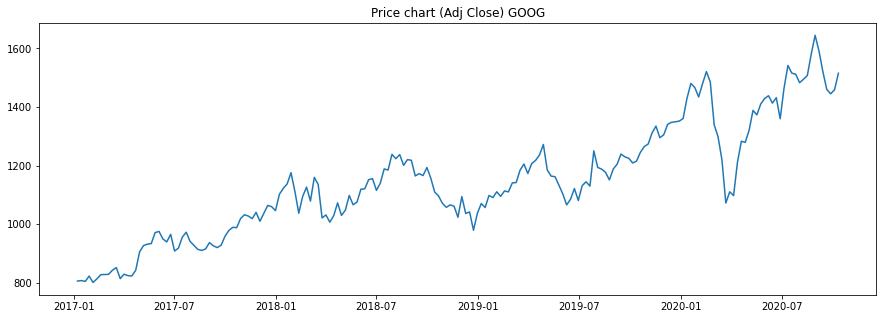

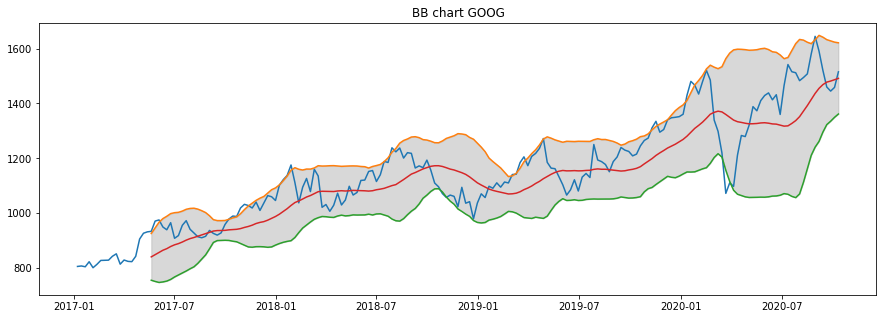

In [235]:
# plot price
plt.figure(figsize=(15,5))
plt.plot(df['Date'], df['Adj Close'])
plt.title('Price chart (Adj Close) ' + str(ticker))
plt.show()


# plot correspondingRSI values and significant levels
plt.figure(figsize=(15,5))
plt.title('BB chart ' + str(ticker))
plt.plot(df['Date'], df['Adj Close'])
plt.plot(df['Date'], df['BU'])
plt.plot(df['Date'], df['BL'])
plt.plot(df['Date'], df['B_MA'])
plt.fill_between(df['Date'], df['BU'], df['BL'], color='grey', alpha=0.3)


plt.show()

     index       Date         Open         High          Low        Close    Adj Close   Volume         B_MA           BU           BL
0       19 2017-05-21   932.950012   943.109985   918.140015   934.010010   934.010010  1485920   841.034035   926.137130   755.930941
1       20 2017-05-28   935.000000   974.979980   935.000000   971.469971   971.469971  1265700   849.227367   946.943029   751.511706
2       21 2017-06-04   970.309998   979.270020   960.010010   975.599976   975.599976  1769075   857.504134   967.149917   747.858352
3       22 2017-06-11   976.549988   988.250000   935.630005   949.830017   949.830017  1862380   865.151468   980.549697   749.753239
4       23 2017-06-18   939.559998   961.150024   915.232971   939.780029   939.780029  2498860   870.937518   989.010406   752.864631
..     ...        ...          ...          ...          ...          ...          ...      ...          ...          ...          ...
173    192 2020-09-13  1533.510010  1584.081055  1497.3

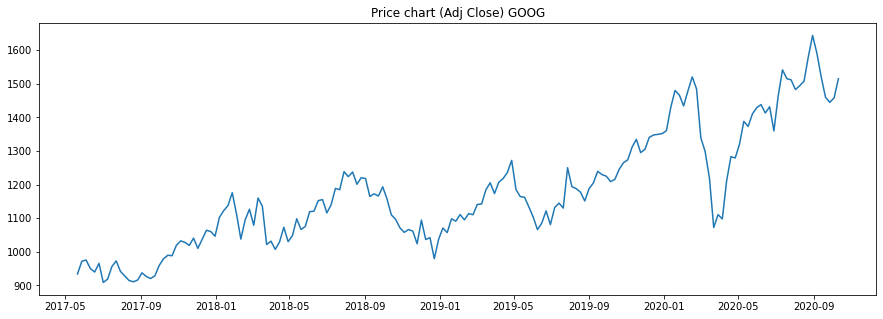

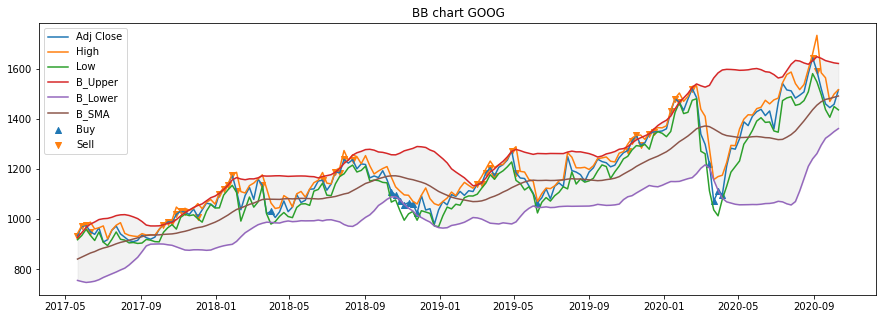

In [236]:
#trading signals:
# rewrite as needed
# partially modified from youtube
# https://www.youtube.com/watch?v=gEIw2iUlFYc&ab_channel=ComputerScience
# still needs some modifications, but at least it is giving signals

period=20
new_df = df[period-1:].copy()
new_df = new_df.reset_index()
print(new_df)


def get_signal(data):
    
    buy_signal = []
    sell_signal = []
    
    print(len(data['Close']))
    print(data['Close'][19])
    
    
    for i in range(len(data['Close'])):
        #if data['Close'][i] > data['BU'][i]: # sell signal    daily
        if data['High'][i] > data['BU'][i]: # sell signal     weekly
            buy_signal.append(np.nan)
            sell_signal.append(data['Close'][i])
        #elif data['Close'][i] < data['BL'][i]:  # buy signal   daily
        elif data['Low'][i] < data['BL'][i]:  # buy signal    weekly
            buy_signal.append(data['Close'][i])
            sell_signal.append(np.nan)  
        else:
            buy_signal.append(np.nan)
            sell_signal.append(np.nan)
            
            
    print(buy_signal)        
            
            
    #returns touple        
    return (buy_signal, sell_signal)
            
#print(new_df)            
            
    
print(get_signal(new_df)[0])    
    
    
new_df['Buy'] = get_signal(new_df)[0]
new_df['Sell'] = get_signal(new_df)[1]


print(new_df)





# plot price
plt.figure(figsize=(15,5))
plt.plot(new_df['Date'], new_df['Adj Close'])
plt.title('Price chart (Adj Close) ' + str(ticker))
plt.show()


# plot correspondingRSI values and significant levels
plt.figure(figsize=(15,5))
plt.title('BB chart ' + str(ticker))
plt.plot(new_df['Date'], new_df['Adj Close'], label='Adj Close')

plt.plot(new_df['Date'], new_df['High'], label='High')
plt.plot(new_df['Date'], new_df['Low'], label='Low')

plt.plot(new_df['Date'], new_df['BU'], label='B_Upper')
plt.plot(new_df['Date'], new_df['BL'], label='B_Lower')
plt.plot(new_df['Date'], new_df['B_MA'], label='B_SMA')
plt.fill_between(new_df['Date'], new_df['BU'], new_df['BL'], color='grey', alpha=0.1)

plt.scatter(new_df['Date'], new_df['Buy'], label='Buy', marker='^')
plt.scatter(new_df['Date'], new_df['Sell'], label='Sell', marker='v')

plt.legend()

plt.show()


#### Sources:
https://github.com/Crypto-toolbox/pandas-technical-indicators   <BR>
https://www.quantopian.com/posts/technical-analysis-indicators-without-talib-code  <BR>
https://www.investopedia.com/terms/b/bollingerbands.asp     <BR>
https://www.youtube.com/watch?v=gEIw2iUlFYc&ab_channel=ComputerScience